# Course: ICS 574
# Prject: Alchemists Project - EDA
- Date: May 1st 2024
- Project Members
    - AHMED DHAFER ALQARNI, ID: 201453160
    - WALEED ABDULLAH ALFAIFI, ID: 201640920
    - ALGHAMDI, BANDAR, ID: 202206560

The project is divided into 6 parts
1. Importing the libraries
2. Preprocessing the data
3. Model Selection

    3.1 Decision Tree Classifier Model

    3.2 Decision Tree Regressor Model

    3.3 GBTRegressor Model

    3.4 Random Forest Regressor Model

    3.5 Support Vector Classifier Model

    3.6 Support Vector Regressor Model
    
4. Model Evaluation

   
    
5. Model Prediction

# Study Goal

The goal of the project is to

# 1. Data Preprocessing

In [2]:
#import needed libraries
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import seaborn as sns
import numpy as np
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# hide WRAN warnings
import warnings
warnings.filterwarnings('ignore')

# Create a Spark session
spark = SparkSession.builder.appName("MarketAlchemists").getOrCreate()
spark


- Preprocess the stock data as done in the EDA Part previously we have seen that the data is not clean and has missing values in Phase 1 of the project
- below code is to import the data, clean it, rename columns, and merge the dataframes as done in the EDA Phase 1 part

In [3]:
# Load the datasets as pandas DataFrames
stocks_df = pd.read_csv("./datasets/Tadawul_stcks.csv")
brent_df = pd.read_csv("./datasets/BrentOilPrices.csv")
gold_df = pd.read_csv("./datasets/Gold_Daily.csv")

# hide warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Preprocess the stock data as done in the EDA Part
# previously we have seen that the data is not clean and has missing values in Phase 1 of the project
# below code is to clean the data, rename the columns and merge the dataframes
# as done in the EDA Phase 1 part
stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
brent_df['Date'] = pd.to_datetime(brent_df['Date'])
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
brent_df = brent_df[['Date', 'Brent_Price']]
gold_df = gold_df[['Date', 'Gold_Price']]
stocks_specific_df.fillna(method='ffill', inplace=True)
stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')

# define a function that does all the above data preprocessing steps so we can use it before we try different models with original data
def preprocess_data(stocks_df, brent_df, gold_df):
    stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
    stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
    stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
    stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
    brent_df['Date'] = pd.to_datetime(brent_df['Date'])
    gold_df['Date'] = pd.to_datetime(gold_df['Date'])
    brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
    gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
    stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
    brent_df = brent_df[['Date', 'Brent_Price']]
    gold_df = gold_df[['Date', 'Gold_Price']]
    stocks_specific_df.fillna(method='ffill', inplace=True)
    stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
    stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')
    return stocks_brent_gold_df


In [4]:
# Create a Spark DataFrame
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [5]:
# print dataframe to check if it is created successfully
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E8|    4576.0|      51.29|    1690.5|
|  2380|Rabigh Refining a...|   PETRO RABIGH|   Energy|

In [6]:
# print features of the dataframe
stocks_brent_gold_df_spark.printSchema()

root
 |-- symbol: long (nullable = true)
 |-- name: string (nullable = true)
 |-- trading_name : string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- Stock_Price: double (nullable = true)
 |-- change: double (nullable = true)
 |-- perc_Change: double (nullable = true)
 |-- volume_traded : double (nullable = true)
 |-- value_traded: double (nullable = true)
 |-- no_trades : double (nullable = true)
 |-- Brent_Price: double (nullable = true)
 |-- Gold_Price: double (nullable = true)



In [68]:
# print features types
stocks_brent_gold_df_spark.printSchema()

root
 |-- symbol: long (nullable = true)
 |-- name: string (nullable = true)
 |-- trading_name : string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- Stock_Price: double (nullable = true)
 |-- change: double (nullable = true)
 |-- perc_Change: double (nullable = true)
 |-- volume_traded : double (nullable = true)
 |-- value_traded: double (nullable = true)
 |-- no_trades : double (nullable = true)
 |-- Brent_Price: double (nullable = true)
 |-- Gold_Price: double (nullable = true)
 |-- Price_Change: string (nullable = false)
 |-- label: double (nullable = false)
 |-- nameIndex: double (nullable = false)
 |-- SectorIndex: double (nullable = false)



# 2. Model Selection

In this section, we cover the usage of various models to identify the best option to go with: Decision Tree, Regression Tree, SVM

# 2.1 Model Selection: Decision Tree Model

In [62]:
# adding a new Price_Change column to the DataFrame, since the label should be categorical in Decision Trees and later indexed
# this column will be used to determine if the stock price increased or decreased from the previous day
# create a new colum checking the "change" column; if it's greater than 0, it's an increase, otherwise it's a decrease
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Price_Change",
                        F.when(F.col("change") > 0, "1")
                        .otherwise("0"))


# Convert Price_Change to a numerical label
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
stocks_brent_gold_df_spark = label_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/04/30 13:52:20 WARN TaskSetManager: Stage 82 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [63]:
# view the dataframe for Saudi Basic Industries Corporation (SABIC) to check if the new column is added
stocks_brent_gold_df_spark.filter(F.col("symbol") == "2010").show(100)


+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+
|symbol|                name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|
+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+
|  2010|Saudi Basic Indus...|        SABIC|Materials|2020-01-23 00:00:00| 91.7| 91.7| 90.2|       90.9|  -0.9|      -0.98|     1589177.0| 1.444986769E8|    3737.0|      61.26|    1608.3|           0|  0.0|
|  2010|Saudi Basic Indus...|        SABIC|Materials|2020-01-22 00:00:00| 92.0| 92.3| 91.8|       91.8|  -0.2|      -0.22|      864850.0|  7.96494069E7|    2065.0|      62.11| 

In [64]:
# Create StringIndexers for categorical columns
name_indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
sector_indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")

# create StringIndexers for the categorical columns and add them to the dataframe
stocks_brent_gold_df_spark = name_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
stocks_brent_gold_df_spark = sector_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/04/30 13:52:34 WARN TaskSetManager: Stage 86 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 13:52:34 WARN TaskSetManager: Stage 89 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [65]:
# print the dataframe to check if the new columns are added
stocks_brent_gold_df_spark.show(10)

+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|symbol|                name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|
+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|  2030|Saudi Arabia Refi...|        SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|
|  2222|Saudi Arabian Oil...| SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.

In [69]:
# extract date only from the Date column to use it as a feature in a new column
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Date", F.to_date(F.col("Date")))

In [70]:
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|symbol|                name|  trading_name |   Sector|      Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|
+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05|33.05| 33.2|32.95|       33.0| -0.05|      -0.15| 

In [72]:
# transform Date to datetype
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Date", F.to_date(F.col("Date")))
# create a new column with the year of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Year", F.year(F.col("Date")))
# create a new column with the month of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Month", F.month(F.col("Date")))
# create a new column with the day of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Day", F.dayofmonth(F.col("Date")))

In [73]:
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+----+-----+---+
|symbol|                name|  trading_name |   Sector|      Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|Year|Month|Day|
+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+----+-----+---+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|2020|    3|  5|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2

In [74]:
# Create a VectorAssembler for the features selected
assembler = VectorAssembler(inputCols=["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price", "Year", "Month", "Day"], outputCol="features")
stocks_brent_gold_df_spark = assembler.transform(stocks_brent_gold_df_spark)

In [75]:
# Train-test split
splits = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]

In [77]:
# Define the DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=47)
pipeline = Pipeline(stages=[name_indexer, sector_indexer, symbol_indexer, assembler, dt])
model = dt.fit(train) # Train the model on the training data

24/04/30 13:59:32 WARN TaskSetManager: Stage 110 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 13:59:32 WARN TaskSetManager: Stage 111 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 13:59:32 WARN TaskSetManager: Stage 113 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 13:59:32 WARN TaskSetManager: Stage 115 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 13:59:32 WARN TaskSetManager: Stage 117 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 13:59:33 WARN TaskSetManager: Stage 119 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 13:59:33 WARN TaskSetManager: Stage 121 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.

In [78]:
# Make predictions on the test data
predictions = model.transform(test)

In [79]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.5700503162073581


24/04/30 13:59:36 WARN TaskSetManager: Stage 123 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [83]:
# create a table for the predictions and the actual labels for SABIC for dates after 2018
predictions.createOrReplaceTempView("predictions")
sabic_predictions = spark.sql("SELECT name, Date, Stock_Price, Brent_Price, Gold_Price, label, prediction FROM predictions WHERE name = 'Saudi Basic Industries Corp.' AND Date > '2018-01-01'").show(500)


+--------------------+----------+-----------+-----------+----------+-----+----------+
|                name|      Date|Stock_Price|Brent_Price|Gold_Price|label|prediction|
+--------------------+----------+-----------+-----------+----------+-----+----------+
|Saudi Basic Indus...|2019-04-25|      123.4|      74.94|    1330.2|  1.0|       0.0|
|Saudi Basic Indus...|2019-05-01|      124.8|      72.01|    1334.2|  1.0|       0.0|
|Saudi Basic Indus...|2019-05-09|      115.8|      70.61|    1335.1|  0.0|       0.0|
|Saudi Basic Indus...|2019-05-28|      110.4|      70.19|    1323.3|  1.0|       0.0|
|Saudi Basic Indus...|2019-05-30|      111.8|      69.55|    1341.4|  1.0|       0.0|
|Saudi Basic Indus...|2019-06-10|      118.0|      64.31|    1374.3|  1.0|       0.0|
|Saudi Basic Indus...|2019-06-13|      118.2|      63.28|    1388.1|  0.0|       0.0|
|Saudi Basic Indus...|2019-06-20|      119.0|      65.44|    1436.0|  1.0|       0.0|
|Saudi Basic Indus...|2019-07-10|      114.0|      66.

24/04/30 14:00:56 WARN TaskSetManager: Stage 135 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:00:56 WARN TaskSetManager: Stage 136 contains a task of very large size (1100 KiB). The maximum recommended task size is 1000 KiB.


In [84]:
# print the feature importances in a more readable way
feature_importances = model.featureImportances.toArray()
feature_names = ["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price", "Year", "Month", "Day"]
for i in range(len(feature_importances)):
    print(feature_names[i], ":", feature_importances[i])

nameIndex : 0.10331783817882435
SectorIndex : 0.0
Stock_Price : 0.13571053044241815
Brent_Price : 0.008480713925128806
Gold_Price : 0.01604546727762458
Year : 0.6356896303525787
Month : 0.04702644751014714
Day : 0.05372937231327827


In [85]:
# redo the same steps with the original data without the Dates
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Price_Change",
                        F.when(F.col("change") > 0, "1")
                        .otherwise("0"))
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
stocks_brent_gold_df_spark = label_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
name_indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
sector_indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
stocks_brent_gold_df_spark = name_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
stocks_brent_gold_df_spark = sector_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
assembler = VectorAssembler(inputCols=["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = assembler.transform(stocks_brent_gold_df_spark)
splits = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=47)
pipeline = Pipeline(stages=[name_indexer, sector_indexer, assembler, dt])
model = dt.fit(train)
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# print the feature importances in a more readable way
feature_importances = model.featureImportances.toArray()
feature_names = ["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price"]
for i in range(len(feature_importances)):
    print(feature_names[i], ":", feature_importances[i])


24/04/30 14:03:11 WARN TaskSetManager: Stage 137 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:03:12 WARN TaskSetManager: Stage 140 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:03:12 WARN TaskSetManager: Stage 143 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:03:12 WARN TaskSetManager: Stage 147 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:03:12 WARN TaskSetManager: Stage 148 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:03:13 WARN TaskSetManager: Stage 150 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:03:13 WARN TaskSetManager: Stage 152 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.

Accuracy: 0.5714219823808865
nameIndex : 0.04369758333007596
SectorIndex : 0.0
Stock_Price : 0.20865090681932527
Brent_Price : 0.07817510870947712
Gold_Price : 0.6694764011411217


# 2.2 Model Selection: Regression Model

In [86]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [87]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
indexed = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
indexer = StringIndexer(inputCol="name", outputCol="StockIndex")
indexed = indexer.fit(indexed).transform(indexed)

24/04/30 14:03:50 WARN TaskSetManager: Stage 162 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:03:50 WARN TaskSetManager: Stage 165 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [88]:
# verify the indexing
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|      18.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E

In [89]:
# create a feature vector by combining the features that we are going to use
vectorAssembler = VectorAssembler(inputCols=["Stock_Price", "volume_traded ", "value_traded", "no_trades ", "Brent_Price", "Gold_Price"], outputCol="features")

In [90]:
# Create a VectorAssembler for the features
stocks_brent_gold_df_spark = vectorAssembler.transform(indexed)

In [91]:
# show the datframe to verify features column
stocks_brent_gold_df_spark.show(truncate=False)

+------+----------------------------------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+---------------------------------------------------+
|symbol|name                                          |trading_name   |Sector   |Date               |open |high |low  |Stock_Price|change|perc_Change|volume_traded |value_traded  |no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|features                                           |
+------+----------------------------------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+---------------------------------------------------+
|2030  |Saudi Arabia Refineries Co.                   |SARCO          |Energy   |2020-03-05 00:00:00|35.55|35.85|34.9 |34.9       

In [20]:
# cross validation on spark doesn't respect the time in time-series; test:train is better on spark
# equivilant of sklearn.model_selection.TimeSeriesSplit
# else: hold-out method
# later on, use other models: SVM (super vector machine) / MLP / etc

In [92]:
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])


In [93]:
# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

In [94]:
# define the evaluator
# note the metricName parameter is rmse, which stands for Root Mean Squared Error. This is the default metric for regression problems.
# Other metrics include r2 (R squared) and mae (Mean Absolute Error)
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")

In [95]:
# Define the grid of hyperparameters
# We will use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for dt.maxDepth and 5 values for dt.maxBins, this grid will have 3 x 5 = 15 parameter settings for CrossValidator to choose from.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 3, 4, 5, 6, 7, 8, 9, 10]) \
    .addGrid(dt.maxBins, [10, 20, 40, 80, 100]) \
    .build()

In [96]:
# Define the CrossValidator
# We will use a CrossValidator to select the best model.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [97]:
# fit the cv model with the assembled data
cvModel = cv.fit(stocks_brent_gold_df_spark)

24/04/30 14:04:19 WARN TaskSetManager: Stage 170 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:04:20 WARN TaskSetManager: Stage 172 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:04:20 WARN TaskSetManager: Stage 173 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:04:20 WARN TaskSetManager: Stage 175 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:04:20 WARN TaskSetManager: Stage 177 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:04:20 WARN TaskSetManager: Stage 179 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:04:20 WARN TaskSetManager: Stage 180 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.

In [98]:
# get the average cross-validated RMSE
# note the RMSE is the root of the average of the squares of the differences between the predicted and the actual values
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator

# the higher the RMSE, the worse the model
# the lower the RMSE, the better the model
# the RMSE is a measure of the quality of the model
# the RMSE is scale-dependent
# the RMSE can be used to compare different models
# the RMSE can be used to compare different transformations of the same model
# the RMSE can be used to compare different models on different datasets
# the RMSE can be used to compare different models on the same dataset
# the RMSE can be used to compare different models on the same dataset with different target variables
# the RMSE can be used to compare different models on the same dataset with the same target variable
# the RMSE can be used to compare different models on the same dataset with the same target variable and different features
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features and different hyperparameters
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features and the same hyperparameters
# the RMSE value of 0 means the model is perfect
# the RMSE value of 9 means the model is good?
avg_rmse = np.mean(cvModel.avgMetrics)
print("Average RMSE: ", avg_rmse)

Average RMSE:  9.586654099504663


In [99]:
# print all the parameters of the best model
print(cvModel.bestModel.extractParamMap())

{Param(parent='DecisionTreeRegressor_6e3f970e77d7', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeRegressor_6e3f970e77d7', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeRegressor_6e3f970e77d7', name='featuresCol', doc='features column name.'): 'features', Param(parent='DecisionTreeRegressor_6e3f970e77d7', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Para

In [100]:
# print the RMSE of all the models, just to view the difference in the cross-validated RMSE
for rmse in cvModel.avgMetrics:
    print(rmse)

10.52253169479995
10.519868734130924
10.518814164490525
10.520756779886081
10.519285577170434
10.153186514733566
10.105834322149942
10.072283976575653
10.08226525844436
10.071360791611957
9.96268297851359
9.898815480151583
9.82397994515233
9.836700029520152
9.813131032420348
9.765980025638813
9.715624261251467
9.631983213224576
9.61888623376545
9.599802853860366
9.630919573708876
9.549850255441914
9.47218956211819
9.469353958678642
9.438601740696154
9.5048665662421
9.395855185940913
9.332556599899625
9.33052683652834
9.3020170047672
9.380310056503617
9.257054804725524
9.172233377122964
9.168754793889383
9.14005146261915
9.252624660073343
9.1062296406464
9.014275184181052
9.009122389933118
8.981775451433887
9.134575712439494
8.971029103041191
8.888103872213359
8.881221413634075
8.861561403739284


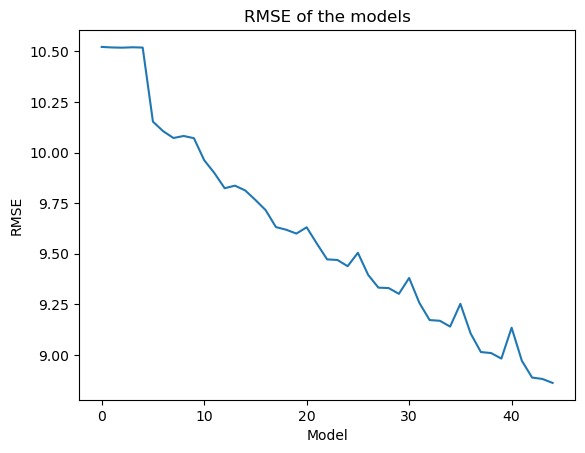

In [101]:
# plot all the RMSE values of the models to see the difference in the cross-validated RMSE
plt.plot(cvModel.avgMetrics)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of the models')
plt.show()

In [102]:
# print the feature importances

# The feature importances represent the importance of each feature in the decision tree model.

# The feature importances are calculated based on the information gain provided by each feature in splitting the data.

# The higher the feature importance, the more important the feature is in making predictions.



# get the feature importances
feature_importances = cvModel.bestModel.featureImportances

# create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame(list(zip(stocks_brent_gold_df_spark.columns[2:], feature_importances)),
                                      columns=["Feature", "Importance"])

# sort the DataFrame by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# display the feature importances
print(feature_importances_df)

         Feature  Importance
0  trading_name     0.441327
5            low    0.279748
3           open    0.108535
4           high    0.078467
1         Sector    0.050756
2           Date    0.041167


In [103]:
# print the feature importances
# Feature importances describe the relative importance of each feature in making accurate predictions.
# The higher the value, the more important the feature is.
# Feature importances can help you understand which features are most influential in your model's predictions.
# Feature importances can guide feature selection and model interpretation.

# get the feature importances
feature_importances = cvModel.bestModel.featureImportances

# create a pandas DataFrame to display the feature importances
feature_importances_df = pd.DataFrame(list(zip(["Stock_Price", "Brent_Price", "Gold_Price"], feature_importances)),
                                      columns=["Feature", "Importance"])

# display the feature importances
print(feature_importances_df)

       Feature  Importance
0  Stock_Price    0.441327
1  Brent_Price    0.050756
2   Gold_Price    0.041167


In [104]:
# print the hyperparameters of the best model
# The hyperparameters of the best model can provide insights into the configuration that yielded the best performance.
# Understanding the hyperparameters can help you tune future models and optimize their performance.
# The hyperparameters of the best model can guide further experimentation and refinement of the model.
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getMaxBins())

10
100


+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2020-01-23 00:00:00|       90.9|11.192941176470589|
|2020-01-22 00:00:00|       91.8|19.924812030075188|
|2020-01-21 00:00:00|       92.0| 7.715242881072027|
|2020-01-20 00:00:00|       92.9|19.924812030075188|
|2020-01-16 00:00:00|       92.8| 7.715242881072027|
|2020-01-15 00:00:00|       92.4| 7.715242881072027|
|2020-01-14 00:00:00|       93.2|11.192941176470589|
|2020-01-13 00:00:00|       92.7|11.192941176470589|
|2020-01-09 00:00:00|       92.0|11.192941176470589|
|2020-01-08 00:00:00|       90.5|11.192941176470589|
|2020-01-07 00:00:00|       91.0|11.192941176470589|
|2020-01-06 00:00:00|       91.9|11.192941176470589|
|2020-01-02 00:00:00|       93.4|11.192941176470589|
|2020-01-01 00:00:00|       93.1|11.192941176470589|
|2019-12-31 00:00:00|       93.9| 7.715242881072027|
|2019-12-30 00:00:00|       93.7|11.1929411764

24/04/30 14:08:02 WARN TaskSetManager: Stage 4255 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:03 WARN TaskSetManager: Stage 4256 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


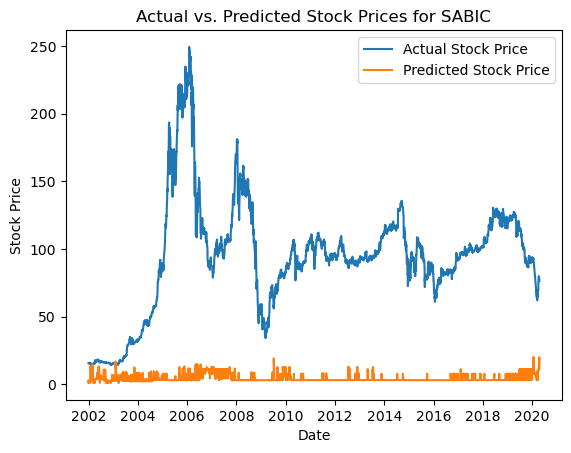

In [105]:
# create a table for SABIC actual and predicted stock prices

# get the predictions
predictions = cvModel.transform(stocks_brent_gold_df_spark)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show()

# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

- we notice that the DecisionTreeRegressor model is not performing well; this can be due to the fact that the cross-validation is not respecting the time in the time-series data

- we can try to use the test:train split method instead of cross-validation to verify if it yeilds better results

In [106]:
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

# Train the model on the training data
model = dt.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/04/30 14:08:12 WARN TaskSetManager: Stage 4258 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:12 WARN TaskSetManager: Stage 4259 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:12 WARN TaskSetManager: Stage 4261 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:12 WARN TaskSetManager: Stage 4263 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:12 WARN TaskSetManager: Stage 4265 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:12 WARN TaskSetManager: Stage 4267 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:12 WARN TaskSetManager: Stage 4269 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Root Mean Squared Error (RMSE): 9.620496658624036


In [107]:
# we do non-random split to respect the time in the time-series data
# we split the data by date
# the training data is before 2018 and the testing data is after 2018
trainingData2 = stocks_brent_gold_df_spark.filter(stocks_brent_gold_df_spark.Date < '2018-01-01')
testData2 = stocks_brent_gold_df_spark.filter(stocks_brent_gold_df_spark.Date >= '2018-01-01')

# Define the DecisionTreeRegressor
dt2 = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

# Train the model on the training data
model2 = dt.fit(trainingData2)

# Make predictions on the test data
predictions2 = model2.transform(testData2)

# Evaluate the model
evaluator2 = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")
rmse2 = evaluator2.evaluate(predictions2)
print("Root Mean Squared Error (RMSE):", rmse2)

24/04/30 14:08:21 WARN TaskSetManager: Stage 4274 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:21 WARN TaskSetManager: Stage 4275 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4276 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4278 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4280 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4282 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4284 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Root Mean Squared Error (RMSE): 12.913640337534394


- from above, we see Regression isn't yeilding good results

# 2.3 Model Selection: GBTRgressor

Gradient-Boosted Trees (GBTs) learning algorithm for regression. It supports both continuous and categorical features.

In [152]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [153]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
stocks_brent_gold_df_spark = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
stocks_brent_gold_df_spark = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/04/30 22:24:09 WARN TaskSetManager: Stage 4337 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:24:09 WARN TaskSetManager: Stage 4340 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [156]:
# duplicate the label column to use it as a feature
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("label", stocks_brent_gold_df_spark["Stock_Price"])

In [157]:
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+---------+-----+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|nameIndex|label|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+---------+-----+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|     18.0| 34.9|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     396

In [158]:
# create feature vector
vectorAssembler = VectorAssembler(inputCols=["SectorIndex", "Stock_Price", "nameIndex", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = vectorAssembler.transform(stocks_brent_gold_df_spark)


In [161]:
# implement a model that predicts the stock price of SABIC
# we have various models to choose from, such as DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, etc.
# each model has its own strengths and weaknesses
# we can use the GBTRgressor model to predict the stock price of SABIC
# the GBTRegressor model is an ensemble model that uses multiple decision trees to make predictions
# the GBTRegressor model is a powerful model that can capture complex relationships in the data
# the GBTRegressor model is a popular model for regression problems
# the GBTRegressor model is a good choice for predicting the stock price of SABIC
from pyspark.ml.regression import GBTRegressor
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxBins=47)

# Train the model on the training data
model = gbt.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/04/30 22:25:44 WARN TaskSetManager: Stage 4348 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:25:44 WARN TaskSetManager: Stage 4349 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:25:44 WARN TaskSetManager: Stage 4351 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:25:45 WARN TaskSetManager: Stage 4353 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:25:45 WARN TaskSetManager: Stage 4355 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:25:45 WARN TaskSetManager: Stage 4357 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:25:45 WARN TaskSetManager: Stage 4359 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Root Mean Squared Error (RMSE): 3.8057568713181227


24/04/30 22:25:49 WARN TaskSetManager: Stage 4551 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:25:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [166]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", mse)

24/04/30 22:39:04 WARN TaskSetManager: Stage 4556 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE): 14.483785363585104


In [164]:
# print the accuracy of the model
# The accuracy of the model is a measure of how well the model is able to predict the stock price of SABIC.

# The accuracy of the model is calculated by comparing the predicted stock price to the actual stock price.

# The accuracy of the model is a measure of the quality of the model.


# get the predictions
predictions = model.transform(testData)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show(100)



+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2019-04-25 00:00:00|      123.4|119.32563464593943|
|2019-05-07 00:00:00|      119.6|119.32563464593943|
|2019-05-28 00:00:00|      110.4|119.32563464593943|
|2019-06-24 00:00:00|      113.6|119.23582365998045|
|2019-07-16 00:00:00|      114.4|119.23582365998045|
|2019-07-22 00:00:00|      110.6|119.23582365998045|
|2019-07-24 00:00:00|      110.0|119.23582365998045|
|2019-07-25 00:00:00|      111.0|119.23582365998045|
|2019-08-01 00:00:00|      106.4|102.06721350548482|
|2019-08-05 00:00:00|      102.0|102.06721350548482|
|2019-08-27 00:00:00|      101.2| 102.0899667774657|
|2019-08-28 00:00:00|      100.6| 102.0899667774657|
|2019-08-29 00:00:00|       99.9| 102.0899667774657|
|2019-09-03 00:00:00|       99.7| 102.0899667774657|
|2019-09-10 00:00:00|       96.5|  91.4216470471321|
|2019-09-11 00:00:00|       94.4|  91.42164704

24/04/30 22:33:49 WARN TaskSetManager: Stage 4555 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


# SGD

In [168]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [169]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
stocks_brent_gold_df_spark = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
stocks_brent_gold_df_spark = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/04/30 22:40:04 WARN TaskSetManager: Stage 4558 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:40:04 WARN TaskSetManager: Stage 4561 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [170]:
# duplicate the label column to use it as a feature
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("label", stocks_brent_gold_df_spark["Stock_Price"])

In [171]:
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+---------+-----+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|nameIndex|label|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+---------+-----+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|     18.0| 34.9|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     396

In [172]:
# create feature vector
vectorAssembler = VectorAssembler(inputCols=["SectorIndex", "Stock_Price", "nameIndex", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = vectorAssembler.transform(stocks_brent_gold_df_spark)

In [174]:
# implement a Stochastic Gradient Descent - SGD
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the Stochastic Gradient Descent - SGD
from pyspark.ml.regression import GeneralizedLinearRegression
sgd = GeneralizedLinearRegression(featuresCol="features", labelCol="label")

# Train the model on the training data
model = sgd.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/04/30 22:41:08 WARN Instrumentation: [768d380d] regParam is zero, which might cause numerical instability and overfitting.
24/04/30 22:41:08 WARN TaskSetManager: Stage 4565 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 22:41:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/04/30 22:41:09 WARN TaskSetManager: Stage 4567 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE): 1.7426981571734428e-14


In [175]:
# print the accuracy of the model
# The accuracy of the model is a measure of how well the model is able to predict the stock price of SABIC.

# The accuracy of the model is calculated by comparing the predicted stock price to the actual stock price.


# get the predictions
predictions = model.transform(testData)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show(100)



+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2019-04-15 00:00:00|      125.0|124.99999999999996|
|2019-04-22 00:00:00|      124.2|124.19999999999996|
|2019-04-29 00:00:00|      124.0|123.99999999999996|
|2019-04-30 00:00:00|      124.2|124.19999999999996|
|2019-05-15 00:00:00|      111.8|111.79999999999997|
|2019-05-22 00:00:00|      112.4|112.39999999999998|
|2019-06-20 00:00:00|      119.0|118.99999999999996|
|2019-07-18 00:00:00|      114.2|114.19999999999997|
|2019-08-19 00:00:00|      104.2|104.19999999999997|
|2019-08-21 00:00:00|      102.4|102.39999999999998|
|2019-08-22 00:00:00|      102.4|102.39999999999998|
|2019-09-03 00:00:00|       99.7| 99.69999999999997|
|2019-09-10 00:00:00|       96.5| 96.49999999999997|
|2019-09-25 00:00:00|       92.8| 92.79999999999997|
|2019-10-10 00:00:00|       88.5| 88.49999999999999|
|2019-10-14 00:00:00|       88.2| 88.199999999

24/04/30 22:42:09 WARN TaskSetManager: Stage 4570 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
# try the model again without the Stock_Price column

# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
stocks_brent_gold_df_spark = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
stocks_brent_gold_df_spark = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("label", stocks_brent_gold_df_spark["Stock_Price"])

# 2.4 Model Selection: SVMModel

In [77]:
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+-----+--------------------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|label|            features|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+-----+--------------------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0| 18.0|[34.9,436609.0,1....|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|3

In [81]:
# drop the label column
indexed = indexed.drop("label")

In [79]:
# add a new column to the DataFrame that indicates if the stock price increased or decreased from the previous day, with label 1 for increase and 0 for decrease
# this column will be used as the label for the model
indexed = indexed.withColumn("Price_Change",
                        F.when(F.col("Stock_Price") > F.lag("Stock_Price").over(Window.orderBy("Date")), 1)
                        .otherwise(0))

# Convert Price_Change to a numerical label
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
indexed = label_indexer.fit(indexed).transform(indexed)

24/04/29 20:53:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:53:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:53:56 WARN TaskSetManager: Stage 4360 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:53:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:53:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [83]:
# rename Price_Change column to label
indexed = indexed.withColumnRenamed("Price_Change", "label")

In [84]:
indexed.show()

+------+--------------------+--------------+---------+-------------------+-----+-----+-----+-----------+-------+-----------+--------------+-------------+----------+-----------+----------+-----------+--------------------+-----+
|symbol|                name| trading_name |   Sector|               Date| open| high|  low|Stock_Price| change|perc_Change|volume_traded | value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|            features|label|
+------+--------------------+--------------+---------+-------------------+-----+-----+-----+-----------+-------+-----------+--------------+-------------+----------+-----------+----------+-----------+--------------------+-----+
|  4030|National Shipping...|         BAHRI|   Energy|2001-12-31 00:00:00| 9.25| 9.25| 9.25|       9.25|   9.25|        0.0|      256935.0|    2367154.5|      44.0|      19.35|     278.7|        1.0|[9.25,256935.0,23...|    0|
|  2010|Saudi Basic Indus...|         SABIC|Materials|2001-12-31 00:00:00|15.75|15.75| 15.5|

24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:27 WARN TaskSetManager: Stage 4369 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [85]:
from pyspark.mllib.linalg import SparseVector
# implement the model using SVMModel
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = indexed.randomSplit([0.8, 0.2])

# Define the SVMModel
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol="features", labelCol="label")

# Train the model on the training data
model = svm.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN TaskSetManager: Stage 4372 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN WindowEx

Accuracy: 0.6846435960127891


In [86]:
# split the data with the time-series in mind
# we split the data by date
# the training data is before 2018 and the testing data is after 2018
trainingData = indexed.filter(indexed.Date < '2018-01-01')
testData = indexed.filter(indexed.Date >= '2018-01-01')

# Define the SVMModel
svm = LinearSVC(featuresCol="features", labelCol="label")

# Train the model on the training data
model = svm.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN TaskSetManager: Stage 4676 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN WindowEx

Accuracy: 0.6246453182002432


# Model Validation

In [88]:
# print number of correct predictions
correct_predictions = predictions.filter(predictions.label == predictions.prediction).count()
print("Number of correct predictions:", correct_predictions)

# print number of incorrect predictions
incorrect_predictions = predictions.filter(predictions.label != predictions.prediction).count()
print("Number of incorrect predictions:", incorrect_predictions)

24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN TaskSetManager: Stage 5081 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Number of correct predictions: 12328
Number of incorrect predictions: 7408


24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN TaskSetManager: Stage 5084 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [99]:
# print the feature importances
# Feature importances describe the relative importance of each feature in making accurate predictions.

# The higher the value, the more important the feature is.

# Feature importances can help you understand which features are most influential in your model's predictions.


# get the feature importances
feature_importances = model.coefficients

# create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame(list(zip(["Stock_Price", "Brent_Price", "Gold_Price", "volume_traded", "value_traded", "no_trades"], feature_importances)),
                                      columns=["Feature", "Importance"])

# sort the DataFrame by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# display the feature importances
print(feature_importances_df)

         Feature    Importance
0    Stock_Price  4.711053e-02
5      no_trades  7.807593e-04
3  volume_traded  1.767314e-05
1    Brent_Price  9.761599e-09
2     Gold_Price -1.712160e-09
4   value_traded -1.306478e-02


In [15]:
"""

an RMSE of 9.841781224229344 means that, on average, the model's predictions are about 9.84 units away from the actual values.

Whether this RMSE is considered good or bad depends on the context and the scale of your data. For example, if you are predicting stock prices that range from 100 to 200, an RMSE of 9.84 might be acceptable. However, if your stock prices range from 10 to 20, an RMSE of 9.84 would be quite high, indicating that your model's predictions are not very accurate.

It's also important to compare this RMSE to the performance of other models or benchmarks. If other models or approaches yield significantly lower RMSE values, then an RMSE of 9.84 might be considered suboptimal.

Considering your project involves predicting the exact prices of stocks, Brent oil, Ethereum, and gold, the evaluation of the RMSE value depends on the specific context:

Stock Prices: If the stock prices you're predicting have a wide range (e.g., $50 to $300), an RMSE of 9.84 might be considered reasonable. However, for lower-priced stocks or if you aim for high precision, this RMSE could be considered high.
Brent Oil Prices: The price range for Brent oil can vary significantly depending on market conditions. If the range is broad, an RMSE of 9.84 might be acceptable. However, for more stable periods with narrower price ranges, this value might be too high.
Ethereum Prices: Given the volatility and wide range of cryptocurrency prices, an RMSE of 9.84 could be considered reasonable, but this depends on the specific price range during your prediction period.
Gold Prices: Similar to Brent oil, the evaluation of the RMSE for gold prices depends on the price range during the period you're predicting. For a wide range, an RMSE of 9.84 might be acceptable, but for a narrower range, it could be considered high.
Overall, the acceptability of an RMSE of 9.84 in your project depends on the specific price ranges and volatility of the assets you're predicting. It's also important to compare this value to other models or benchmarks to evaluate its relative performance.


"""

"\n\nan RMSE of 9.841781224229344 means that, on average, the model's predictions are about 9.84 units away from the actual values.\n\nWhether this RMSE is considered good or bad depends on the context and the scale of your data. For example, if you are predicting stock prices that range from 100 to 200, an RMSE of 9.84 might be acceptable. However, if your stock prices range from 10 to 20, an RMSE of 9.84 would be quite high, indicating that your model's predictions are not very accurate.\n\nIt's also important to compare this RMSE to the performance of other models or benchmarks. If other models or approaches yield significantly lower RMSE values, then an RMSE of 9.84 might be considered suboptimal.\n\nConsidering your project involves predicting the exact prices of stocks, Brent oil, Ethereum, and gold, the evaluation of the RMSE value depends on the specific context:\n\nStock Prices: If the stock prices you're predicting have a wide range (e.g., $50 to $300), an RMSE of 9.84 might 

# Hyperparameter Tuning 

# Performance Metrics

# Results Analysis

In [44]:
# Stop the Spark session
spark.stop()